To prevent the infinite waiting of MCMC/VB, I will do the rest of reproducing of the paper here.  

In [6]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt


%pylab inline 
# magic fucntion in ipython. It loads major numerical and plotting libraries


# import class for constructing random walks
from pymc3.distributions.timeseries import GaussianRandomWalk
import theano.tensor as tt

#import some special methods
from scipy.special import logit,expit
import scipy.stats as stats

# set some plotting parameters to create ggplot-style plots
import seaborn as sns
import matplotlib as mpl
sns.set_context(context='talk',font_scale=1.5)
plt.style.use('ggplot')
mpl.rcParams['axes.labelsize'] = 24

#interactive plotting tools
from ipywidgets import interactive

Populating the interactive namespace from numpy and matplotlib


In [124]:
data = pd.read_csv('./data/data_sample.csv')
data

,month,overdoses,fentanyl deaths,deaths,kits distributed,kits used
0,1,221,2,23,34.0,2
1,2,254,10,31,35.0,0
2,3,266,9,25,110.0,3
3,4,408,27,42,140.0,10
4,5,661,52,68,360.0,19
5,6,965,78,87,752.0,78
6,7,1377,128,132,793.0,101
7,8,1512,146,151,823.0,110
8,9,1640,164,170,903.0,159
9,10,1630,150,153,908.0,137


In [11]:
# plot data 
def plot_dataframe(data):
    '''plot example data from data frame
    
    '''
    plt.figure(figsize=(16,16));
    names = data.columns
    observables = [c for c in names if c!= 'month']
    for i,j in enumerate(observables):
        plt.subplot(3,2,i+1);
        plt.plot(np.arange(1, n_months+1), data[j].values);
        plt.ylabel(j);
        if (i==4) or (i==5):
            plt.xlabel('month');

In [13]:
n_months=12

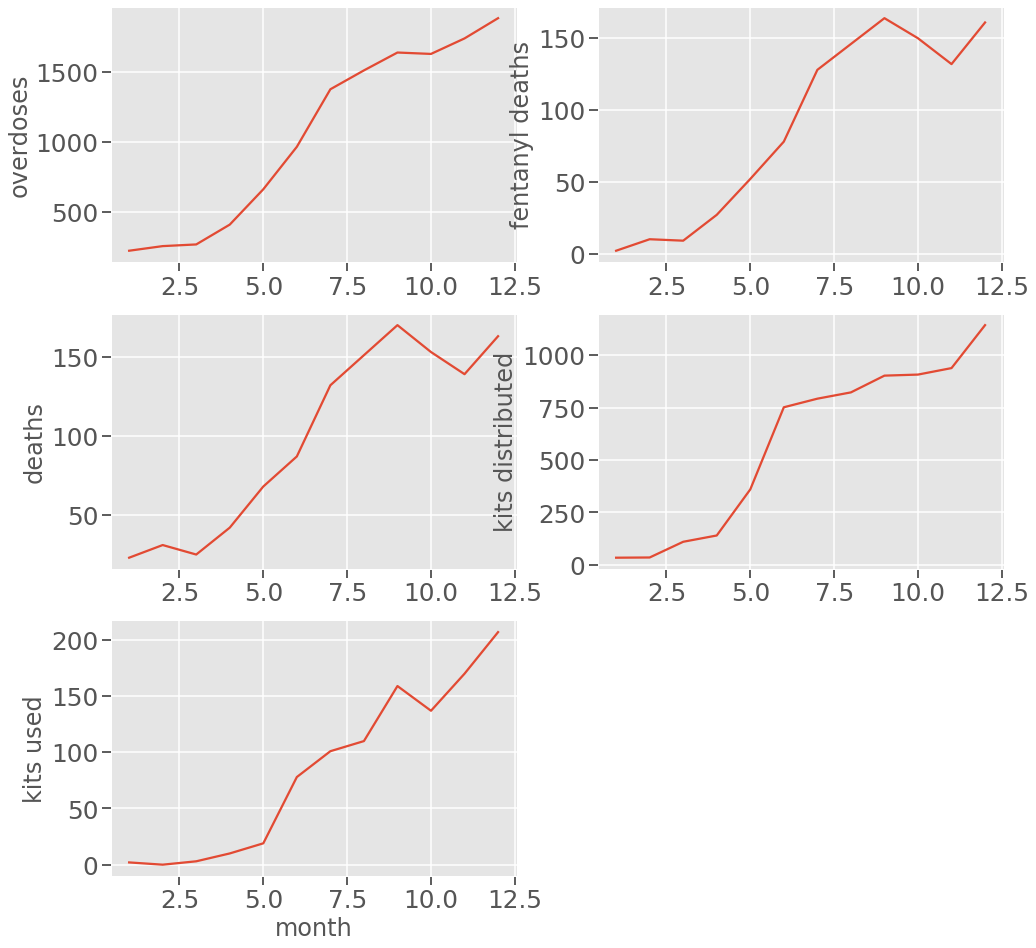

In [14]:
plot_dataframe(data)

In [18]:

def create_timeseries_death_model(N_mean = 10000, N_sd = 1000, 
                            p0 = 0.01,
                            mu_w=0.0, sigma_w = 0.1,
                            mu_pd = 0.1, sigma_pd = 0.05,
                            overdoses = None,deaths = None):
    """
    Create pymc3 time-series overdose model
    
    Parameters
    ----------
    N_mean : float
        mean of population size
    N_sd : float
        standard deviation of population size
    p0 : float
        initial prevalence of overdoses
    mu_w : float
        drift for overdose random walk
    sd_w : float
        variance for overdose random walk
    mu_pd : float
        mean probability of death following an overdose
    sigma_pd : float
        sd probability of death following an overdose
    overdoses : numpy array
        overdose data
    deaths : numpy array
        death data
    
    Returns
    -------
    
    Pymc3 model
    
    """
    
    # instantiate model
    model = pm.Model()

    # create elements of the model
    with model:
        # define population size random variable. PyMC3 needs a label for the RV as the first value.
        N = pm.Normal('N',mu=N_mean, sd=N_sd)

        # define random walk process
        w = GaussianRandomWalk('w',mu=mu_w, sd=sigma_w, shape=n_months, 
                               init=pm.Normal.dist(mu=logit(p0), sd=0.1))
        
        # convert random walk into probability
        p = pm.Deterministic('p',pm.math.invlogit(w))
        
        # probability of death following an overdose
        pd = pm.Beta('p_d',mu=mu_pd,sd=sigma_pd)
        

        # generate data (we assume we haven't observed any data so far to draw from the prior)
        if overdoses is not None:
            x = pm.Poisson('overdoses',mu=N*p,shape=(n_months,), observed=overdoses)
            
        if deaths is not None:
            x = pm.Poisson('deaths',mu=N*p*pd,shape=(n_months,), observed=deaths)
    
    return model

def generate_ppc_from_model(model):
    '''
    Generate trace and ppc from a pymc3 model using variational Bayes.
    
    Parameters
    ----------
    
    model : pymc3 model
    
    Return
    ------
    
    dict
        dictionary containing the trace and ppc
    '''
    # generate trace of posterior
    
### this is original codes
#     print('Running variational fiiting...')
#     with model:
#         v_params = pm.variational.advi(n=100000)

#     print('Generating trace...')
#     with model:
#         trace = pm.variational.sample_vp(v_params, draws=1000)
###

    # new codes
    print('Running variational fitting and generating trace...')
    with model:
        trace = pm.sample(1000)
#         trace = pm.sample(1000, init='advi', n_init=100000)

    print('Generate ppc...')
    # calculate ppc
    with model:
### this is original codes
#         ppc = pm.sample_ppc(trace)
###
        #new codes
        ppc = pm.sample_posterior_predictive(trace)
    return {'trace':trace,'ppc':ppc}


In [19]:
model= create_timeseries_death_model(overdoses = data['overdoses'].values,
                                               deaths=data['deaths'].values)

In [20]:
random.seed( 30 )
fit = generate_ppc_from_model(model)  

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Running variational fitting and generating trace...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_d, w, N]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:08<00:00, 364.73draws/s]
The acceptance probability does not match the target. It is 0.8828519494538648, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.
  3%|▎         | 66/2000 [00:00<03:46,  8.54it/s]

Generate ppc...


100%|██████████| 2000/2000 [00:03<00:00, 529.03it/s]


In [28]:
def plot_data_timeseries(ys, xs=None, xlabel="Month", ylabel="Overdoses", new_plot=True, color="#E14A33", label=None):
    
    '''
    brief intro: plot 95 and IQR
    parameters:
    -----
    ys: sample size by time numpy array 
    xs: x axis as time
    xlabel: string
    ylabel: string
    new_plot: boolean
        plotting to a new figure or not
    color: str
    label: str
    return
    -----
    
    
    '''
    if xs is None:
        xs = np.arange(1,ys.shape[1]+1)
    
    if new_plot: plt.figure;
        # if we wanna make a new plot, then by using plt.figure function,
        # we create a new plot figure
        
    lc, liqr, m, uiqr, uc = np.percentile(ys, [2.5,25,50,75,97.5], axis=0);
    # now it's time to use the (already) existing plot figure
    plt.fill_between(xs, lc, uc,alpha=0.2 ,color=color);
    plt.fill_between(xs, liqr, uiqr, color=color, alpha=0.2);
    plt.plot(xs,m, color= color, label = label);
    plt.xlabel(xlabel);plt.ylabel(ylabel);
    
    

In [31]:
def plot_compare_ppc_data(ppc, data):
    '''
    plot ppc and data comparison
    
    Parameters
    ----------
    ppc : pymc3 object
    data : pandas dataframe
    '''
    # set the figsize from pyplot (plt) package
    plt.figure(figsize=(14,8))
    
    # set the optimal nrow of subplots matrix
    row_number= np.ceil(len(ppc.keys())/2.)
    # if we have 5 keys, then we get 3 by 2 subplot matrix
    
    # plot subplots for each ppc data and its name
    for index, names in enumerate(ppc.keys()):
        # generate a subplot
        plt.subplot(row_number, 2, index+1);
        plot_data_timeseries(ys= ppc[names], 
                             xs=data['month'].values, 
                            xlabel='Month',
                            ylabel=names,
                            new_plot=False);
        plt.plot(data['month'].values, data[names].values,'ko');
        
        # 
        



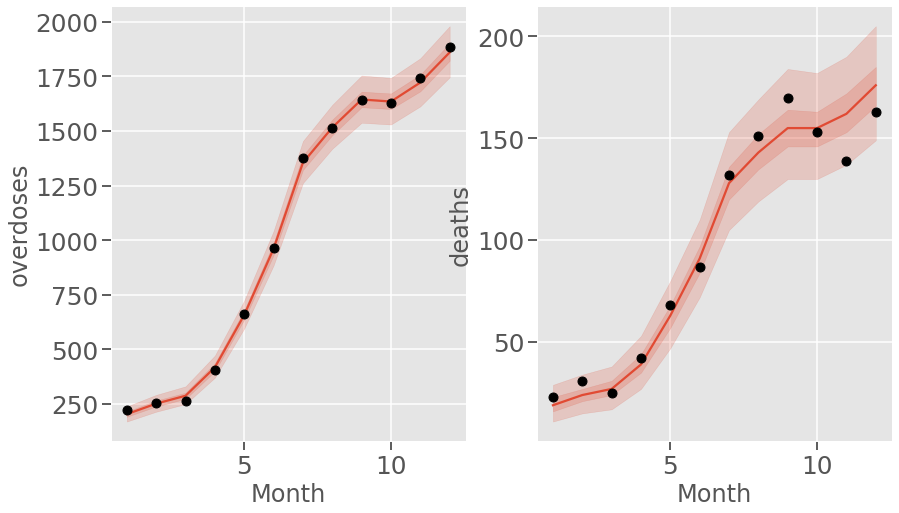

In [32]:
plot_compare_ppc_data(fit['ppc'],data)

yes!!! Finally!!  
# Incorporating fentanyl dynamics

In [79]:
def create_timeseries_fentanyl_death_model(N_mean = 10000, N_sd = 1000, 
                            p0 = 0.01,
                            mu_w=0.0, sigma_w = 0.1,
                            mu_pd = 0.1, sigma_pd = 0.05,
                            mu_kappa_F = 0.25, sigma_kappa_F = 0.1,
                            mu_kappa_N = 0.01, sigma_kappa_N = 0.005,
                            overdoses = None,deaths = None,fentanyl_deaths = None):
    '''
    Create pymc3 time-series overdose model
    
    Parameters
    ----------
    N_mean : float
        mean of population size
    N_sd : float
        standard deviation of population size
    p0 : float
        initial prevalence of fentanyl
    mu_w : float
        drift for fentanyl random walk
    sd_w : float
        variance for fentanyl random walk
    mu_pd : float
        mean probability of death following an overdose
    sigma_pd : float
        sd probability of death following an overdose
    
    overdoses : numpy array
        overdose data
    deaths : numpy array
        total death data
    fentanyl_death : numpy array
        fentanyl deaths data

    Returns
    -------
    Pymc3 model
    '''
    
    with pm.Model() as model:
        N = pm.Normal('N', mu=N_mean, sigma = N_sd)
        w = pm.GaussianRandomWalk('w', mu=mu_w, sigma = sigma_w, shape=(n_months,),
                                  init =pm.Normal.dist(mu=logit(p0),sd=0.01))
        p = pm.Deterministic('p', pm.invlogit(w))
        kappa_F = pm.Beta('kappa_F', mu=mu_kappa_F, sigma=sigma_kappa_F)
        kappa_N = pm.Beta('kappa_N', mu=mu_kappa_N, sigma=sigma_kappa_N)
        pd = pm.Beta('p_d', mu=mu_pd, sigma= sigma_pd)
        
        if overdoses is not None:
            x= pm.Poisson('overdoses', mu=N*(kappa_F*p + kappa_N*(1-p)), shape=(n_months,), observed= overdoses)
        
        if deaths is not None:
            x = pm.Poisson('deaths', mu=N*pd*(kappa_F*p + kappa_N*(1-p)),
                          shape = (n_months,), observed= deaths)
            
        if fentanyl_deaths is not None:
            x=pm.Poisson('fentanyl deaths', mu=N*pd*kappa_F*p,
                        shape=(n_months,), observed= fentanyl_deaths)
            
            
    return model

In [80]:
model =create_timeseries_fentanyl_death_model(sigma_w=1.0, overdoses = data['overdoses'].values,
                                            fentanyl_deaths=data['fentanyl deaths'].values,
                                            deaths=data['deaths'].values)

In [82]:
fit = generate_ppc_from_model(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Running variational fitting and generating trace...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_d, kappa_N, kappa_F, w, N]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:25<00:00, 115.61draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
  0%|          | 0/2000 [00:00<?, ?it/s]

Generate ppc...


100%|██████████| 2000/2000 [00:06<00:00, 300.30it/s]


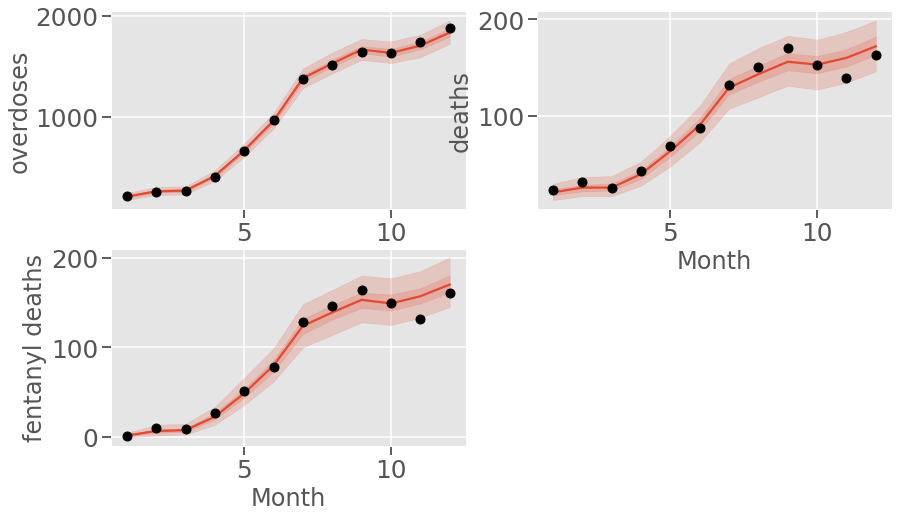

In [83]:
plot_compare_ppc_data(fit['ppc'],data)

In [86]:
fit['trace'].varnames

['N',
 'w',
 'kappa_F_logodds__',
 'kappa_N_logodds__',
 'p_d_logodds__',
 'p',
 'kappa_F',
 'kappa_N',
 'p_d']

In [93]:
def create_timeseries_fentanyl_death_with_thn_model(N_mean = 10000, N_sd = 1000, 
                            p0 = 0.01,
                            mu_w=0.0, sigma_w = 0.1,
                            mu_pd = 0.1, sigma_pd = 0.05,
                            mu_kappa_F = 0.25, sigma_kappa_F = 0.1,
                            mu_kappa_N = 0.01, sigma_kappa_N = 0.005,
                            mu_kappa_THN = 0.9, sigma_kappa_THN = 0.01,
                            overdoses = None,deaths = None,fentanyl_deaths = None,
                            kits_distributed=None, kits_used = None):
    
    """
    Create pymc3 time-series overdose model
    
    Parameters
    ----------
    N_mean : float
        mean of population size
    N_sd : float
        standard deviation of population size
    p0 : float
        initial prevalence of fentanyl
    mu_w : float
        drift for fentanyl random walk
    sd_w : float
        variance for fentanyl random walk
    mu_pd : float
        mean probability of death following an overdose
    sigma_pd : float
        sd probability of death following an overdose
    mu_kappa_F : float
        mean overdose rate on fentanyl
    sd_kappa_F : float
        sd overdose rate on fentanyl 
    mu_kappa_N : float
        mean overdose rate not on fentanyl
    sd_kappa_N : float
        sd overdose rate not on fentanyl 
    mu_kappa_THN : float
        mean effectivess of THN
    sd_kappa_THN : float
        sd effectiveness of THN
    
    kits_distributed: numpy array
    kits_used : numpy array
    overdoses : numpy array
        overdose data
    deaths : numpy array
        total death data
    fentanyl_death : numpy array
        fentanyl deaths data
    
    Returns
    -------
    
    Pymc3 model
    
    """
    
    with pm.Model() as model:
        N = pm.Normal('N', mu=N_mean, sigma = N_sd)
        
        w = pm.GaussianRandomWalk('w', mu=mu_w, sigma = sigma_w, shape=(n_months,),
                                  init =pm.Normal.dist(mu=logit(p0),sd=0.01))
        
        p = pm.Deterministic('p', pm.invlogit(w))
        
        kappa_F = pm.Beta('kappa_F', mu=mu_kappa_F, sigma=sigma_kappa_F)
        
        kappa_N = pm.Beta('kappa_N', mu=mu_kappa_N, sigma=sigma_kappa_N)
        
        kappa_THN = pm.Beta('kappa_THN', mu=mu_kappa_THN, sigma = sigma_kappa_THN)
        
        pd = pm.Beta('p_d', mu=mu_pd, sigma= sigma_pd)
        
        pTHN = kappa_THN*kits_distributed/N
        
        
        if overdoses is not None:
            x= pm.Poisson('overdoses', mu=N*(kappa_F*p + kappa_N*(1-p)), shape=(n_months,), observed= overdoses)
        
        if deaths is not None:
            x = pm.Poisson('deaths', mu=N*pd*(kappa_F*p + kappa_N*(1-p))*(1-pTHN),
                          shape = (n_months,), observed= deaths)
            
        if fentanyl_deaths is not None:
            x=pm.Poisson('fentanyl deaths', mu=N*pd*kappa_F*p*(1-pTHN),
                        shape=(n_months,), observed= fentanyl_deaths)
            
        if kits_used is not None:
            x = pm.Poisson('kits used', mu=N*(kappa_F*p + kappa_N*(1-p))*pTHN,shape=(n_months,), observed=kits_used)
    return model
    

In [94]:
model =create_timeseries_fentanyl_death_with_thn_model(sigma_w=1.0,overdoses=data['overdoses'].values,
                                                        deaths=data['deaths'].values,
                                                        fentanyl_deaths=data['fentanyl deaths'].values,
                                                        kits_used=data['kits used'].values,
                                                        kits_distributed=data['kits distributed'].values)

In [95]:
fit = generate_ppc_from_model(model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Running variational fitting and generating trace...


Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_d, kappa_THN, kappa_N, kappa_F, w, N]
Sampling 2 chains: 100%|██████████| 3000/3000 [00:22<00:00, 134.45draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
  0%|          | 0/2000 [00:00<?, ?it/s]

Generate ppc...


100%|██████████| 2000/2000 [00:12<00:00, 164.28it/s]


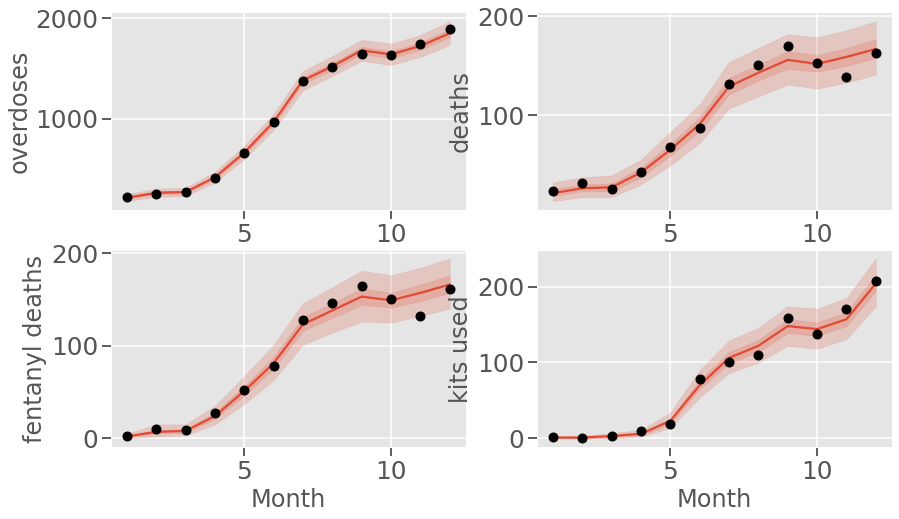

In [97]:
plot_compare_ppc_data(fit['ppc'],data)

# Counterfactual analysis
**Question: why it is justified to use the trace (samples of posterior distribution)   
from the model where we have kits_distributed information to here where we don't have them?**


In [98]:
counterfactualmodel = create_timeseries_fentanyl_death_with_thn_model(sigma_w=1.0,overdoses=data['overdoses'].values,
                                                        deaths=data['deaths'].values,
                                                        fentanyl_deaths=data['fentanyl deaths'].values,
                                                        kits_used=data['kits used'].values,
                                                        kits_distributed=0*data['kits distributed'].values)

In [107]:
with counterfactualmodel:
    counterfactual_ppc = pm. sample_posterior_predictive(fit['trace'])

100%|██████████| 2000/2000 [00:08<00:00, 232.19it/s]


In [108]:
fit['trace'].varnames

['N',
 'w',
 'kappa_F_logodds__',
 'kappa_N_logodds__',
 'kappa_THN_logodds__',
 'p_d_logodds__',
 'p',
 'kappa_F',
 'kappa_N',
 'kappa_THN',
 'p_d']

In [112]:
counterfactual_ppc


{'overdoses': array([[ 213,  252,  276, ..., 1573, 1717, 1807],
        [ 209,  276,  231, ..., 1628, 1623, 1870],
        [ 206,  275,  264, ..., 1722, 1759, 1876],
        ...,
        [ 209,  284,  305, ..., 1624, 1663, 1920],
        [ 191,  253,  270, ..., 1675, 1657, 1879],
        [ 183,  262,  268, ..., 1554, 1725, 1751]]),
 'deaths': array([[ 19,  24,  34, ..., 165, 190, 195],
        [ 20,  31,  32, ..., 190, 170, 176],
        [ 16,  30,  27, ..., 189, 196, 196],
        ...,
        [ 13,  29,  24, ..., 163, 192, 184],
        [ 23,  29,  29, ..., 150, 166, 213],
        [ 12,  42,  20, ..., 172, 183, 184]]),
 'fentanyl deaths': array([[  4,   4,  13, ..., 132, 181, 206],
        [  2,  10,   9, ..., 167, 149, 189],
        [  1,  12,   8, ..., 163, 177, 215],
        ...,
        [  5,   6,  14, ..., 167, 151, 185],
        [  0,  10,   9, ..., 165, 175, 183],
        [  1,  13,   8, ..., 159, 166, 180]]),
 'kits used': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ...

In [113]:
fit['ppc']

{'overdoses': array([[ 202,  268,  263, ..., 1595, 1664, 1790],
        [ 200,  271,  249, ..., 1615, 1698, 1883],
        [ 215,  266,  289, ..., 1779, 1798, 1935],
        ...,
        [ 217,  283,  261, ..., 1600, 1665, 1844],
        [ 199,  252,  247, ..., 1523, 1635, 1839],
        [ 197,  273,  241, ..., 1641, 1639, 1833]]),
 'deaths': array([[ 18,  30,  20, ..., 144, 160, 152],
        [ 12,  26,  22, ..., 155, 141, 192],
        [ 20,  20,  32, ..., 159, 162, 194],
        ...,
        [ 18,  23,  27, ..., 152, 174, 167],
        [ 20,  34,  24, ..., 180, 169, 156],
        [ 21,  19,  24, ..., 147, 165, 172]]),
 'fentanyl deaths': array([[  2,   6,   6, ..., 144, 164, 162],
        [  3,  10,  10, ..., 142, 144, 159],
        [  3,  10,   7, ..., 163, 164, 153],
        ...,
        [  0,   7,  10, ..., 159, 154, 144],
        [  1,   7,   6, ..., 150, 176, 156],
        [  4,  13,  13, ..., 150, 159, 169]]),
 'kits used': array([[  1,   0,   2, ..., 134, 143, 212],
        [

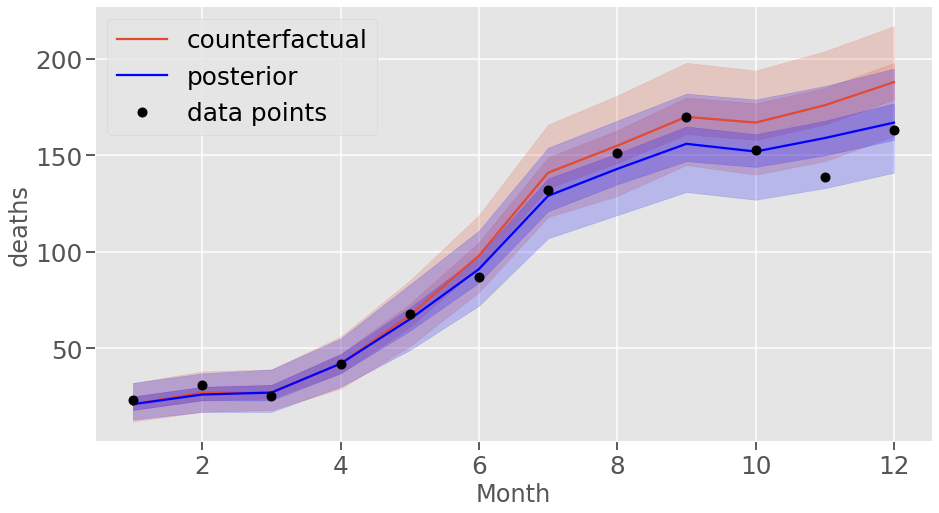

In [123]:
plot_data_timeseries(ys =counterfactual_ppc['deaths'], xs= data['month'], ylabel = 'deaths', new_plot=False,
                    label='counterfactual');
plot_data_timeseries(ys =fit['ppc']['deaths'], xs= data['month'], ylabel = 'deaths', new_plot=False,
                    label='posterior', color='blue');
plt.plot(data['month'],data['deaths'], 'ko', label='data points');
plt.legend()

In [131]:
death_averted = counterfactual_ppc['deaths'] - fit['ppc']['deaths']
death_averted_sum =death_averted.sum(axis=1)

In [130]:
type(death_averted)

numpy.ndarray

In [133]:
shape(death_averted_sum)
# we sum up the difference of the number of deceased people in a year and simulation 2000 times.

(2000,)

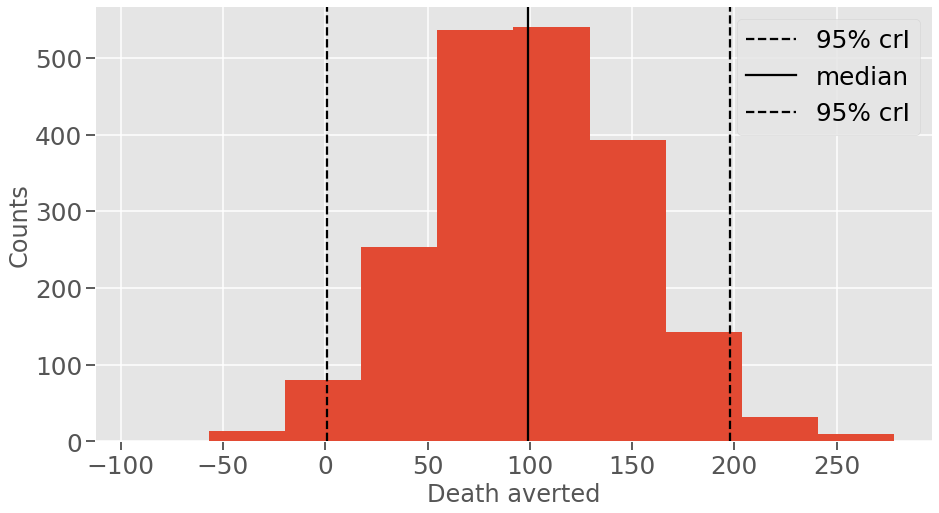

In [143]:
lc, m, uc=np.percentile(death_averted_sum, [2.5, 50, 97.5])
# add a vertical line across the axes 
plt.axvline(x=lc, label='95% crI', ls='--',color='k');
plt.axvline(x=m, label='median', ls='-',color='k');
plt.axvline(x=uc, label='95% crI', ls='--',color='k');
plt.hist(death_averted_sum);
plt.xlabel('Death averted');
plt.ylabel('Counts');
plt.legend();

We can assume that on average 100 people can be saved per year by that amount of distributing kits.

And done for reproducing paper!!!!!!!